# Import Dependencies

In [1]:
import os
import gym
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import time
from random import randint

In [2]:
# Doesn't seem to work, need to manually go find the video
def show_video():
    mp4list = glob.glob('./video\*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

# Install dependencies

The action is an ndarray with shape (1,) which can take values {0, 1} indicating pushing the cart to the left or right, respectively. Note that the velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it.

# Load cartpole env

In [3]:
env = gym.make("CartPole-v1")

Check if there are 2 valid discrete actions that can be performed

In [4]:
print(env.action_space)

Discrete(2)


Display observable space. Note the format of the space being
{
    position
    velocity
    pole angle
    pole angular velocity
}

In [5]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [6]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: (array([-0.04329488, -0.02568009,  0.04148989,  0.03503431], dtype=float32), {})


In [7]:
observation, reward, truncated, done, info = env.step(0)
print(f"""Position: {observation[0]:2f}, 
Velocity: {observation[0]:2f}, 
Angle: {observation[0]:2f}, 
Angular velocity: {observation[0]:2f}""")
print("Reward for this step:", reward)
print("Is this round done?", done)

Position: -0.043808, 
Velocity: -0.043808, 
Angle: -0.043808, 
Angular velocity: -0.043808
Reward for this step: 1.0
Is this round done? False


C:\Users\Tan Say Hong\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Simple game where the policy is to always choose 0.

In [8]:
observation = env.reset()
cumulative_reward = 0
done = False
count = 0
while not done:
    count += 1
    observation, reward, truncated, done, info  = env.step(0)
    cumulative_reward += reward

print(count)
print(f"""Position: {observation[0]:2f}, 
Velocity: {observation[0]:2f}, 
Angle: {observation[0]:2f}, 
Angular velocity: {observation[0]:2f}""")
print("Cumulative reward for this round:", cumulative_reward)

500
Position: -453.199097, 
Velocity: -453.199097, 
Angle: -453.199097, 
Angular velocity: -453.199097
Cumulative reward for this round: 9.0


# Task 1

Development of an RL agent. Demonstrate the correctness of the implementation by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action. Print the values of the state and chosen action in Jupyter notebook.

In [9]:
class CartpoleWorld():
    def __init__(self) -> None:
        self.__env = gym.make("CartPole-v1")
        self.__env.reset()
    def get_observation(self) -> np.ndarray:
        return self.__observation
    def update_world(self,action):
        self.__observation, self.__reward, self.__truncated, self.__done, _ = self.__env.step(action)
        return self.__reward
    def isEnd(self) -> bool:
        return self.__done or self.__truncated
    def get_reward(self):
        return self.__reward
    

In [10]:
class RLAgent():
    def __init__(self, env:CartpoleWorld) -> None:
        self.__env = env
        self.__total_reward = 0
    def get_optimal_action(self):
        pass
    def move(self):
        if (not self.__env.isEnd()):
            raise Exception("Episode already terminated")
        action = self.get_optimal_action()
        reward = self.__env.update_world(action)
        # update reward
        self.__total_reward += reward

agent = RLAgent(CartpoleWorld())

# Task 2:

Demonstrate the effectiveness of the RL agent. Run for 100 episodes (reset the environment at the beginning of each episode) and plot the cumulative reward against all episodes in Jupyter. Print the average reward over the 100 episodes. The average reward should be larger than 195.

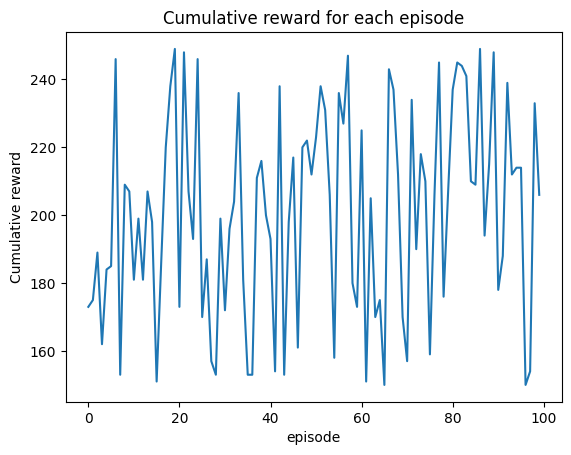

In [11]:
episode_results = np.random.randint(150, 250, size=100)
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [12]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 200.55
Is my agent good enough? True


# Task 3:
Render one episode played by the developed RL agent on Jupyter. Please refer to the sample code link for rendering code

In [13]:

env = gym.make("CartPole-v1", render_mode="rgb_array_list")
env = gym.wrappers.RecordVideo(env, video_folder="./video",  episode_trigger=lambda x:True)
env.reset()

while True:
    env.render()
    
    #your agent goes here
    #use random policy for now
    action = randint(0, 1) #rand_policy_agent(observation)
    observation, reward, done, info, _ = env.step(action) 
    print(observation, reward, done, info, _)
    if done:
        break; 


env.close()

# Doesn't work
#show_video()

[-0.0138995  -0.17136289 -0.00299829  0.2519644 ] 1.0 False False {}
[-0.01732676 -0.3664419   0.002041    0.5437001 ] 1.0 False False {}
[-0.02465559 -0.56159246  0.012915    0.8370254 ] 1.0 False False {}
[-0.03588744 -0.7568884   0.0296555   1.1337417 ] 1.0 False False {}
[-0.05102521 -0.95238566  0.05233034  1.4355761 ] 1.0 False False {}
[-0.07007293 -0.7579466   0.08104187  1.1596949 ] 1.0 False False {}
[-0.08523186 -0.95402545  0.10423576  1.4766481 ] 1.0 False False {}
[-0.10431237 -0.7603197   0.13376872  1.2182564 ] 1.0 False False {}
[-0.11951876 -0.9568883   0.15813385  1.5496861 ] 1.0 False False {}
[-0.13865653 -1.1535147   0.18912756  1.8872435 ] 1.0 False False {}
Moviepy - Building video C:\Users\Tan Say Hong\Documents\GitHub\SC3000-Artificial-Intelligence\video\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\Tan Say Hong\Documents\GitHub\SC3000-Artificial-Intelligence\video\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Tan Say Hong\Documents\GitHub\SC3000-Artificial-Intelligence\video\rl-video-episode-0.mp4
[-0.16172682 -1.3501232   0.22687244  2.23217   ] 1.0 True False {}


# Task 4:

Format the Jupyter notebook by including step-by-step instruction and explanation, such that the notebook is easy to follow and run (refer to the tutorial section in the sample notebook). Include text explanation to demonstrate the originality of your implementation and your understanding of the code. For example, for each task, explain your approach and analyze the output; if you improve an existing approach, explain your improvements.